# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [26]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'], na_values="?")  # Tratar valores ausentes corretamente
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           299 non-null    float64
 12  thal         301 non-null    float64
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(13), int64(2)
memory usage: 35.6 KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [30]:
def bivariada(df, target_var, feature_var):
    """
    Calcula a tabela bivariada para uma variável explicativa em relação ao target.
    
    Parâmetros:
        df (pd.DataFrame): DataFrame com os dados
        target_var (str): Nome da variável resposta (ex: 'flag_doente')
        feature_var (str): Nome da variável explicativa (ex: 'sex')

    Retorno:
        pd.DataFrame: Tabela bivariada com métricas
    """

    # Criar a tabela agregada
    bivariada = df.groupby(feature_var)[target_var].agg(['sum', 'count'])
    bivariada.columns = ['Doentes', 'Total']
    bivariada['Saudáveis'] = bivariada['Total'] - bivariada['Doentes']

    # Quantidade média de doentes
    bivariada['Média de Doentes'] = bivariada['Doentes'] / bivariada['Total']

    # Cálculo das Odds
    bivariada['Odds'] = bivariada['Doentes'] / bivariada['Saudáveis']

    # Odds total (para referência)
    odds_total = bivariada['Doentes'].sum() / bivariada['Saudáveis'].sum()

    # Cálculo do Odds Ratio
    bivariada['Odds Ratio'] = bivariada['Odds'] / odds_total

    # Cálculo do Logito (Log(Odds))
    bivariada['Logito'] = np.log(bivariada['Odds'])

    # Cálculo do Weight of Evidence (WOE)
    bivariada['WOE'] = np.log(bivariada['Odds Ratio'])

    return bivariada

In [32]:
# ---- TESTAR A FUNÇÃO COM VARIÁVEIS QUALITATIVAS ----

# Analisando a variável 'sex' (Sexo: 0 = Mulher, 1 = Homem)
biv_sex = bivariada(df, 'flag_doente', 'sex')
print("\nBivariada para SEXO:\n", biv_sex)

# Analisando a variável 'cp' (Tipo de dor no peito)
biv_cp = bivariada(df, 'flag_doente', 'cp')
print("\nBivariada para TIPO DE DOR NO PEITO (cp):\n", biv_cp)

# Analisando a variável 'thal' (Tipo de thalassemia)
biv_thal = bivariada(df, 'flag_doente', 'thal')
print("\nBivariada para THALASSEMIA (thal):\n", biv_thal)


Bivariada para SEXO:
      Doentes  Total  Saudáveis  Média de Doentes      Odds  Odds Ratio  \
sex                                                                      
0.0       25     97         72          0.257732  0.347222    0.409672   
1.0      114    206         92          0.553398  1.239130    1.461996   

      Logito       WOE  
sex                     
0.0 -1.05779 -0.892398  
1.0  0.21441  0.379802  

Bivariada para TIPO DE DOR NO PEITO (cp):
      Doentes  Total  Saudáveis  Média de Doentes      Odds  Odds Ratio  \
cp                                                                       
1.0        7     23         16          0.304348  0.437500    0.516187   
2.0        9     50         41          0.180000  0.219512    0.258993   
3.0       18     86         68          0.209302  0.264706    0.312315   
4.0      105    144         39          0.729167  2.692308    3.176536   

       Logito       WOE  
cp                       
1.0 -0.826679 -0.661286  
2.0 -1.516347

### Após rodar o código, a variável que tem os maiores valores de Odds Ratio e WOE é a do tipo "Dor n peito (cp)".

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [36]:
def bivariada_continua(df, target_var, feature_var, num_bins=5):
    """
    Realiza uma análise bivariada para variáveis quantitativas contínuas, criando categorias por quantis.

    Parâmetros:
        df (pd.DataFrame): DataFrame com os dados.
        target_var (str): Nome da variável resposta (ex: 'flag_doente').
        feature_var (str): Nome da variável quantitativa (ex: 'age').
        num_bins (int): Número de categorias a serem criadas (default = 5).

    Retorno:
        pd.DataFrame: Tabela bivariada com as métricas estatísticas.
    """

    # Criar categorias da variável contínua usando quantis
    df['bin_' + feature_var] = pd.qcut(df[feature_var], q=num_bins, duplicates='drop')

    # Criar a tabela agregada
    bivariada = df.groupby('bin_' + feature_var)[target_var].agg(['sum', 'count'])
    bivariada.columns = ['Doentes', 'Total']
    bivariada['Saudáveis'] = bivariada['Total'] - bivariada['Doentes']

    # Quantidade média de doentes
    bivariada['Média de Doentes'] = bivariada['Doentes'] / bivariada['Total']

    # Cálculo das Odds
    bivariada['Odds'] = bivariada['Doentes'] / bivariada['Saudáveis']

    # Odds total (para referência)
    odds_total = bivariada['Doentes'].sum() / bivariada['Saudáveis'].sum()

    # Cálculo do Odds Ratio
    bivariada['Odds Ratio'] = bivariada['Odds'] / odds_total

    # Cálculo do Logito (Log(Odds))
    bivariada['Logito'] = np.log(bivariada['Odds'])

    # Cálculo do Weight of Evidence (WOE)
    bivariada['WOE'] = np.log(bivariada['Odds Ratio'])

    return bivariada

# Testando a função com a variavel "age"

biv_age = bivariada_continua(df, 'flag_doente', 'age', num_bins=5)
print("\nBivariada para IDADE:\n", biv_age)


Bivariada para IDADE:
                 Doentes  Total  Saudáveis  Média de Doentes      Odds  \
bin_age                                                                 
(28.999, 45.0]       16     63         47          0.253968  0.340426   
(45.0, 53.0]         22     64         42          0.343750  0.523810   
(53.0, 58.0]         39     71         32          0.549296  1.218750   
(58.0, 62.0]         32     45         13          0.711111  2.461538   
(62.0, 77.0]         30     60         30          0.500000  1.000000   

                Odds Ratio    Logito       WOE  
bin_age                                         
(28.999, 45.0]    0.401653 -1.077559 -0.912166  
(45.0, 53.0]      0.618020 -0.646627 -0.481235  
(53.0, 58.0]      1.437950  0.197826  0.363218  
(58.0, 62.0]      2.904261  0.900787  1.066179  
(62.0, 77.0]      1.179856  0.000000  0.165392  


C:\Users\djang\AppData\Local\Temp\ipykernel_9928\3740403352.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bivariada = df.groupby('bin_' + feature_var)[target_var].agg(['sum', 'count'])


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [56]:
# Ajustar o modelo de regressão logística
reglog = smf.logit("flag_doente ~ cp + trestbps + sex", data=df).fit()

# Exibir os resultados
print(reglog.summary())

Optimization terminated successfully.
         Current function value: 0.529834
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      299
Method:                           MLE   Df Model:                            3
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                  0.2318
Time:                        15:06:20   Log-Likelihood:                -160.54
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 7.200e-21
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.7087      1.355     -6.426      0.000     -11.365      -6.052
cp             1.1540      0.

### Conclusões
* O modelo mostra que cp, trestbps e sex influenciam o risco de doença cardíaca.
* O sexo masculino (sex = 1) é um fator de risco importante.
* A pressão arterial (trestbps) tem um efeito pequeno, mas significativo.
* O tipo de dor no peito (cp) é o fator mais forte na predição.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

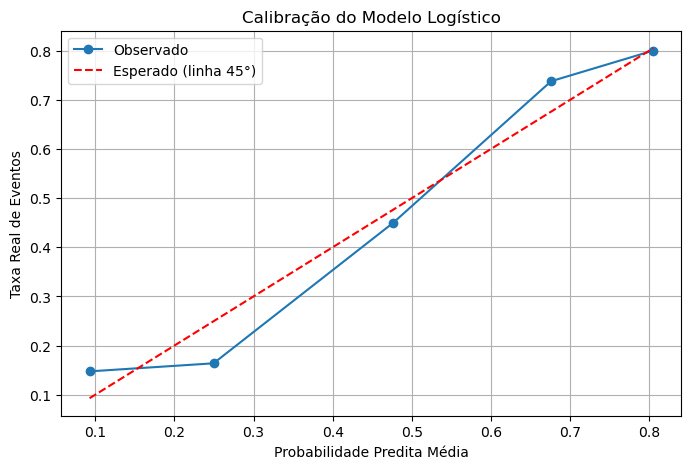

In [65]:
# Calcular probabilidade predita pelo modelo
df['prob_predita'] = reglog.predict()

# Categorizar a probabilidade em 5 grupos (quintis)
df['grupo'] = pd.qcut(df['prob_predita'], q=5, labels=False) + 1  # Grupos de 1 a 5

# Calcular estatísticas por grupo
calibragem = df.groupby('grupo').agg(
    prob_predita_media=('prob_predita', 'mean'),   # Probabilidade média prevista
    taxa_real_eventos=('flag_doente', 'mean')      # Proporção real de doentes
).reset_index()

# Criar gráfico de calibração
plt.figure(figsize=(8,5))
plt.plot(calibragem['prob_predita_media'], calibragem['taxa_real_eventos'], 'o-', label="Observado")
plt.plot(calibragem['prob_predita_media'], calibragem['prob_predita_media'], 'r--', label="Esperado (linha 45°)")
plt.xlabel("Probabilidade Predita Média")
plt.ylabel("Taxa Real de Eventos")
plt.title("Calibração do Modelo Logístico")
plt.legend()
plt.grid()
plt.show()

### Conciderando que a linha azul "observado" não está muito longe da vermelha "esperado", esse modelo predita realmente reflete as chances reais da população.

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [74]:
# Criar um limiar de decisão (0.5 por padrão)
df['predicao_binaria'] = (df['prob_predita'] >= 0.5).astype(int)

# Calcular Acurácia
acuracia = accuracy_score(df['flag_doente'], df['predicao_binaria'])

# Calcular AUC (Área sob a curva ROC)
auc = roc_auc_score(df['flag_doente'], df['prob_predita'])

# Calcular GINI (2 * AUC - 1)
gini = 2 * auc - 1

# Calcular KS (Kolmogorov-Smirnov)
fpr, tpr, thresholds = roc_curve(df['flag_doente'], df['prob_predita'])
ks = max(tpr - fpr)

# Exibir os resultados
print(f"Acurácia: {acuracia:.4f}")
print(f"AUC: {auc:.4f}")
print(f"GINI: {gini:.4f}")
print(f"KS: {ks:.4f}")

Acurácia: 0.7723
AUC: 0.8138
GINI: 0.6276
KS: 0.5409


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

Optimization terminated successfully.
         Current function value: 0.427674
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            7
Date:                Fri, 28 Feb 2025   Pseudo R-squ.:                  0.3799
Time:                        15:19:41   Log-Likelihood:                -129.59
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 5.706e-31
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.6103      2.285     -2.456      0.014     -10.088      -1.133
cp             0.8016      0.

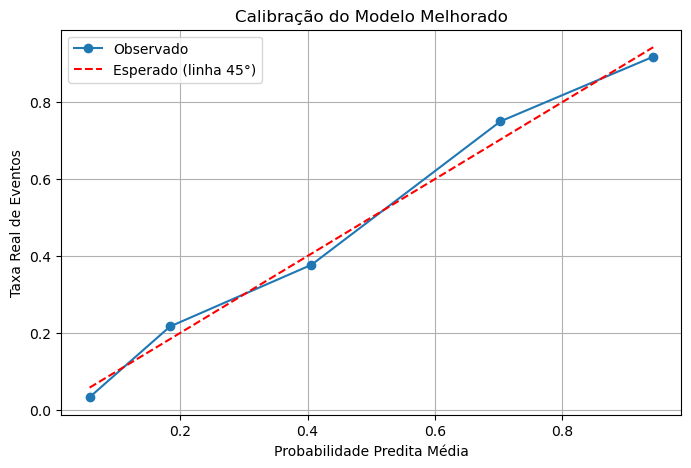

In [76]:
# Testar um novo modelo adicionando mais variáveis
formula = "flag_doente ~ cp + trestbps + sex + age + thalach + exang + oldpeak"
reglog = smf.logit(formula, data=df).fit()

# Calcular probabilidade predita pelo novo modelo
df['prob_predita'] = reglog.predict()

# Criar um limiar de decisão (0.5 por padrão)
df['predicao_binaria'] = (df['prob_predita'] >= 0.5).astype(int)

# Calcular Acurácia
acuracia = accuracy_score(df['flag_doente'], df['predicao_binaria'])

# Calcular AUC (Área sob a curva ROC)
auc = roc_auc_score(df['flag_doente'], df['prob_predita'])

# Calcular GINI (2 * AUC - 1)
gini = 2 * auc - 1

# Calcular KS (Kolmogorov-Smirnov)
fpr, tpr, thresholds = roc_curve(df['flag_doente'], df['prob_predita'])
ks = max(tpr - fpr)

# Exibir os resultados do novo modelo
print(reglog.summary())
print(f"Acurácia: {acuracia:.4f}")
print(f"AUC: {auc:.4f}")
print(f"GINI: {gini:.4f}")
print(f"KS: {ks:.4f}")

# Calibração - Criar 5 grupos por probabilidade predita
df['grupo'] = pd.qcut(df['prob_predita'], q=5, labels=False) + 1

# Calcular estatísticas por grupo
calibragem = df.groupby('grupo').agg(
    prob_predita_media=('prob_predita', 'mean'),
    taxa_real_eventos=('flag_doente', 'mean')
).reset_index()

# Criar gráfico de calibração
plt.figure(figsize=(8,5))
plt.plot(calibragem['prob_predita_media'], calibragem['taxa_real_eventos'], 'o-', label="Observado")
plt.plot(calibragem['prob_predita_media'], calibragem['prob_predita_media'], 'r--', label="Esperado (linha 45°)")
plt.xlabel("Probabilidade Predita Média")
plt.ylabel("Taxa Real de Eventos")
plt.title("Calibração do Modelo Melhorado")
plt.legend()
plt.grid()
plt.show()